In [142]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

import modules.images.utils as im

In [143]:
# J'aimerais savoir la taille des images de notre jeu de données.
taille_image = cv2.imread("./data/test/apple/0001.png")
taille_image.shape

(32, 32, 3)

In [144]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

TRAIN_DATA_DIR = './data/train'
TRAIN_IMAGE_SIZE = 32
TRAIN_BATCH_SIZE = 32

train_generator = image_data_generator.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='training')
    
validation_generator = image_data_generator.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

Found 2800 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


Afin d’améliorer notre CNN nous avons incorporé 1 à 1 des labels jusqu’à arriver jusqu’à 7 labels (pomme, tank, poisson, bébé, castor, ours, lit). Je ne rajoutais un label que quand le modèle reconnaissait à coup sur l’ensemble des labels précédemment.

Nous avons tout d’abord commencé avec seulement un label (Pomme) puis deux (Pomme et Tank) puis 3 (Pomme, Tank, Poisson) puis nous avons incorporé les autres labels 1 par 1.

Le modèle a été amélioré petit à petit afin d’incorporer de nouvelles couches dans notre CNN ou de nouveaux paramètres.


# Termes expliqués :

1ere convolution à 16 filtres : Cela dans le but que cette première convolution ne soit pas trop aggressive et donc trop clivante. Nous ne voulons pas qu’elle détériore nos images.
Il s’agit du nombre de filtres de sortie dans la convolution.

kernel_size : Il s’agit de la dimension en pixel de la fenêtre de convolution passant devant l’image. Dans notre cas elle fait 3x3. A partir d'une couche de convolution supérieure ou égale à 128 nous l'augmentons à 5x5.

padding "same" : Cela entraîne un remplissage uniforme vers la gauche /  la droite ou vers le haut / le bas de l'input de sorte que l'output ait la même dimension hauteur / largeur que l'input.

activation "elu" : Les fonctions d'activation  ELU ont des valeurs négatives qui poussent la moyenne des activations plus près de zéro. Des activations moyennes plus proches de zéro permettent un apprentissage plus rapide car elles rapprochent le gradient du gradient naturel. Les ELU saturent à une valeur négative lorsque l'argument devient plus petit. La saturation signifie une petite dérivée qui diminue la variation et les informations qui se propagent à la couche suivante.

dropout : Cela permet d'éviter l'overfitting. Dans le cas d'un Dropout à 0.2 cela signifie que 20% des connexions entre les neurones sont retirées.

callback : Cela permet de faire du monitoring. Nous l'avons utilisé afin que le modèle s'arrête lorsque que le delta entre loss et val_loss augmente plusieurs fois de suite. En plus de cela nous avons le paramètre "patience" qui permet de déterminer à partir de combien d'augmentation de ce delta à la suite le modèle arrête de s'entrainer.

validation_split : Cela permet d'avoir automatiquement un split du jeu de données afin d'avoir un jeu de test. dans notre cas il est de 0.2 donc 20% des images. Pour un label de 500 images nous en avons 400 qui serviront pour l'entrainement et 100 pour le test de validation.


In [145]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='elu', kernel_initializer='he_uniform', padding='same', input_shape=(taille_image.shape)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=3, activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=5, activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(Dense(256, activation='elu'))

#Toujours à la fin
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dense_40 (Dense)             (None, 16, 16, 32)        544       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dense_41 (Dense)             (None, 8, 8, 64)         

In [146]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=8)

training = model.fit_generator(train_generator, epochs=30, callbacks=[es_callback], validation_data=validation_generator, shuffle=False)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/30
88/88 [==============================] - 38s 431ms/step - loss: 9.9877 - accuracy: 0.2246 - val_loss: 1.9851 - val_accuracy: 0.2300
Epoch 2/30
88/88 [==============================] - 29s 330ms/step - loss: 1.6963 - accuracy: 0.3657 - val_loss: 1.8151 - val_accuracy: 0.3100
Epoch 3/30
88/88 [==============================] - 34s 385ms/step - loss: 1.5202 - accuracy: 0.4236 - val_loss: 1.8412 - val_accuracy: 0.3143
Epoch 4/30
88/88 [==============================] - 32s 367ms/step - loss: 1.4098 - accuracy: 0.4586 - val_loss: 1.6710 - val_accuracy: 0.3700
Epoch 5/30
88/88 [==============================] - 33s 372ms/step - loss: 1.3445 - accuracy: 0.4804 - val_loss: 1.6253 - val_accuracy: 0.4086
Epoch 6/30
88/88 [==============================] - 34s 382ms/step - loss: 1.2916 - accuracy: 0.5089 - val_loss: 1.4701 - val_accuracy: 0.4171
Epoch 7/30
88/88 [==============================] 

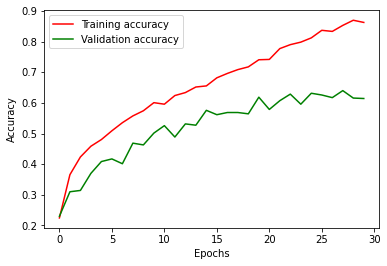

In [147]:
plt.plot(training.history['accuracy'], color='red', label='Training accuracy')
plt.plot(training.history['val_accuracy'],  color='green', label='Validation accuracy')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

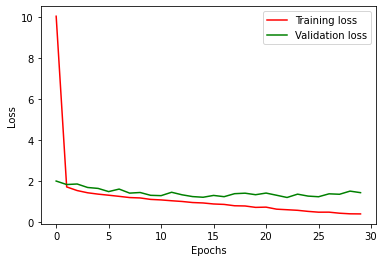

In [148]:
plt.plot(training.history['loss'], color='red', label='Training loss')
plt.plot(training.history['val_loss'],  color='green', label='Validation loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [149]:
layer_outputs = [layer.output for layer in model.layers]

test_image = "./data/test/bear/0001.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32,3))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*13.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')
            activation_index += 1

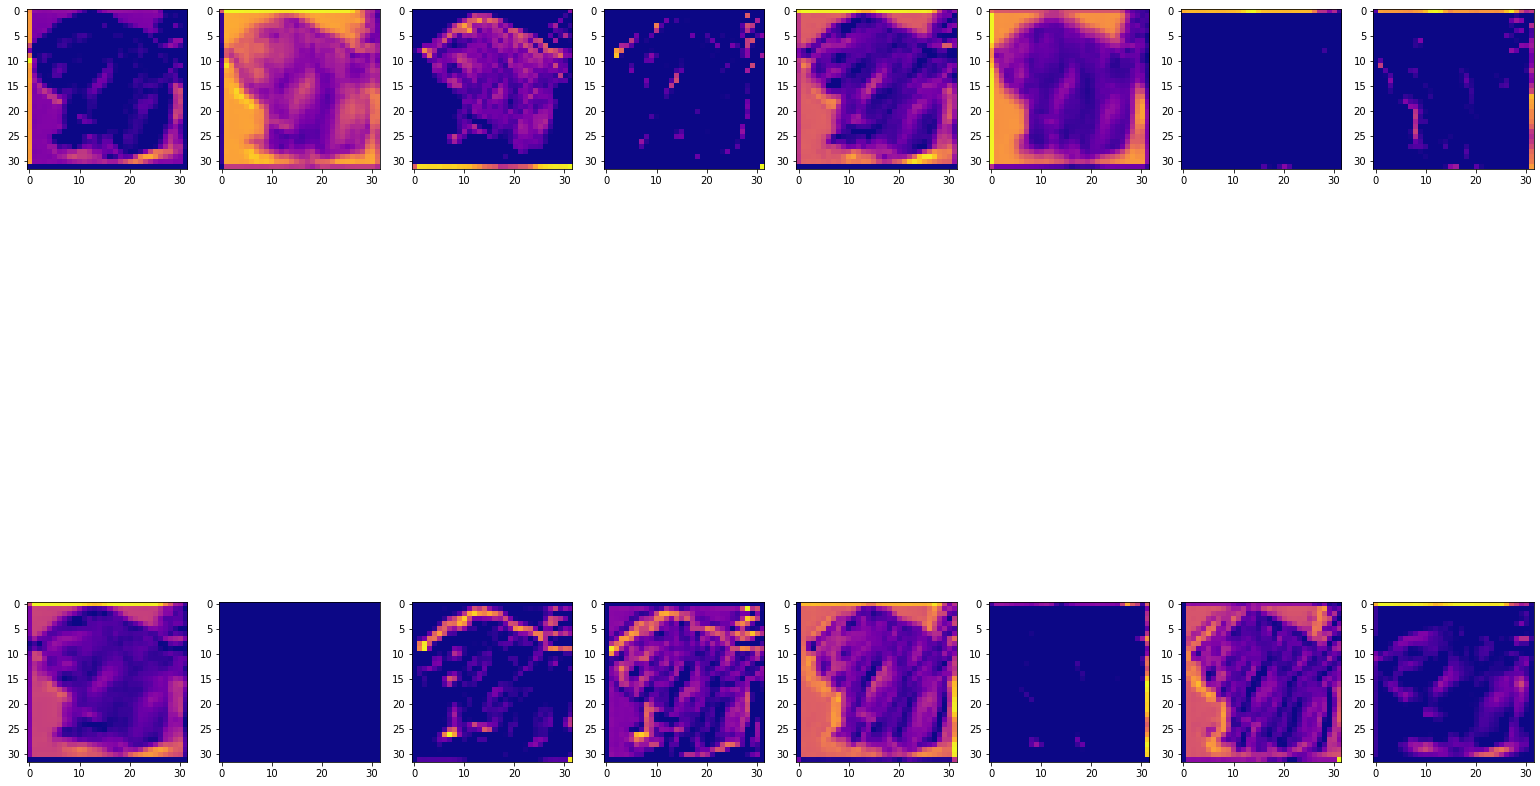

In [150]:
display_activation(activations, 8, 2, 0) # 1ère convolution

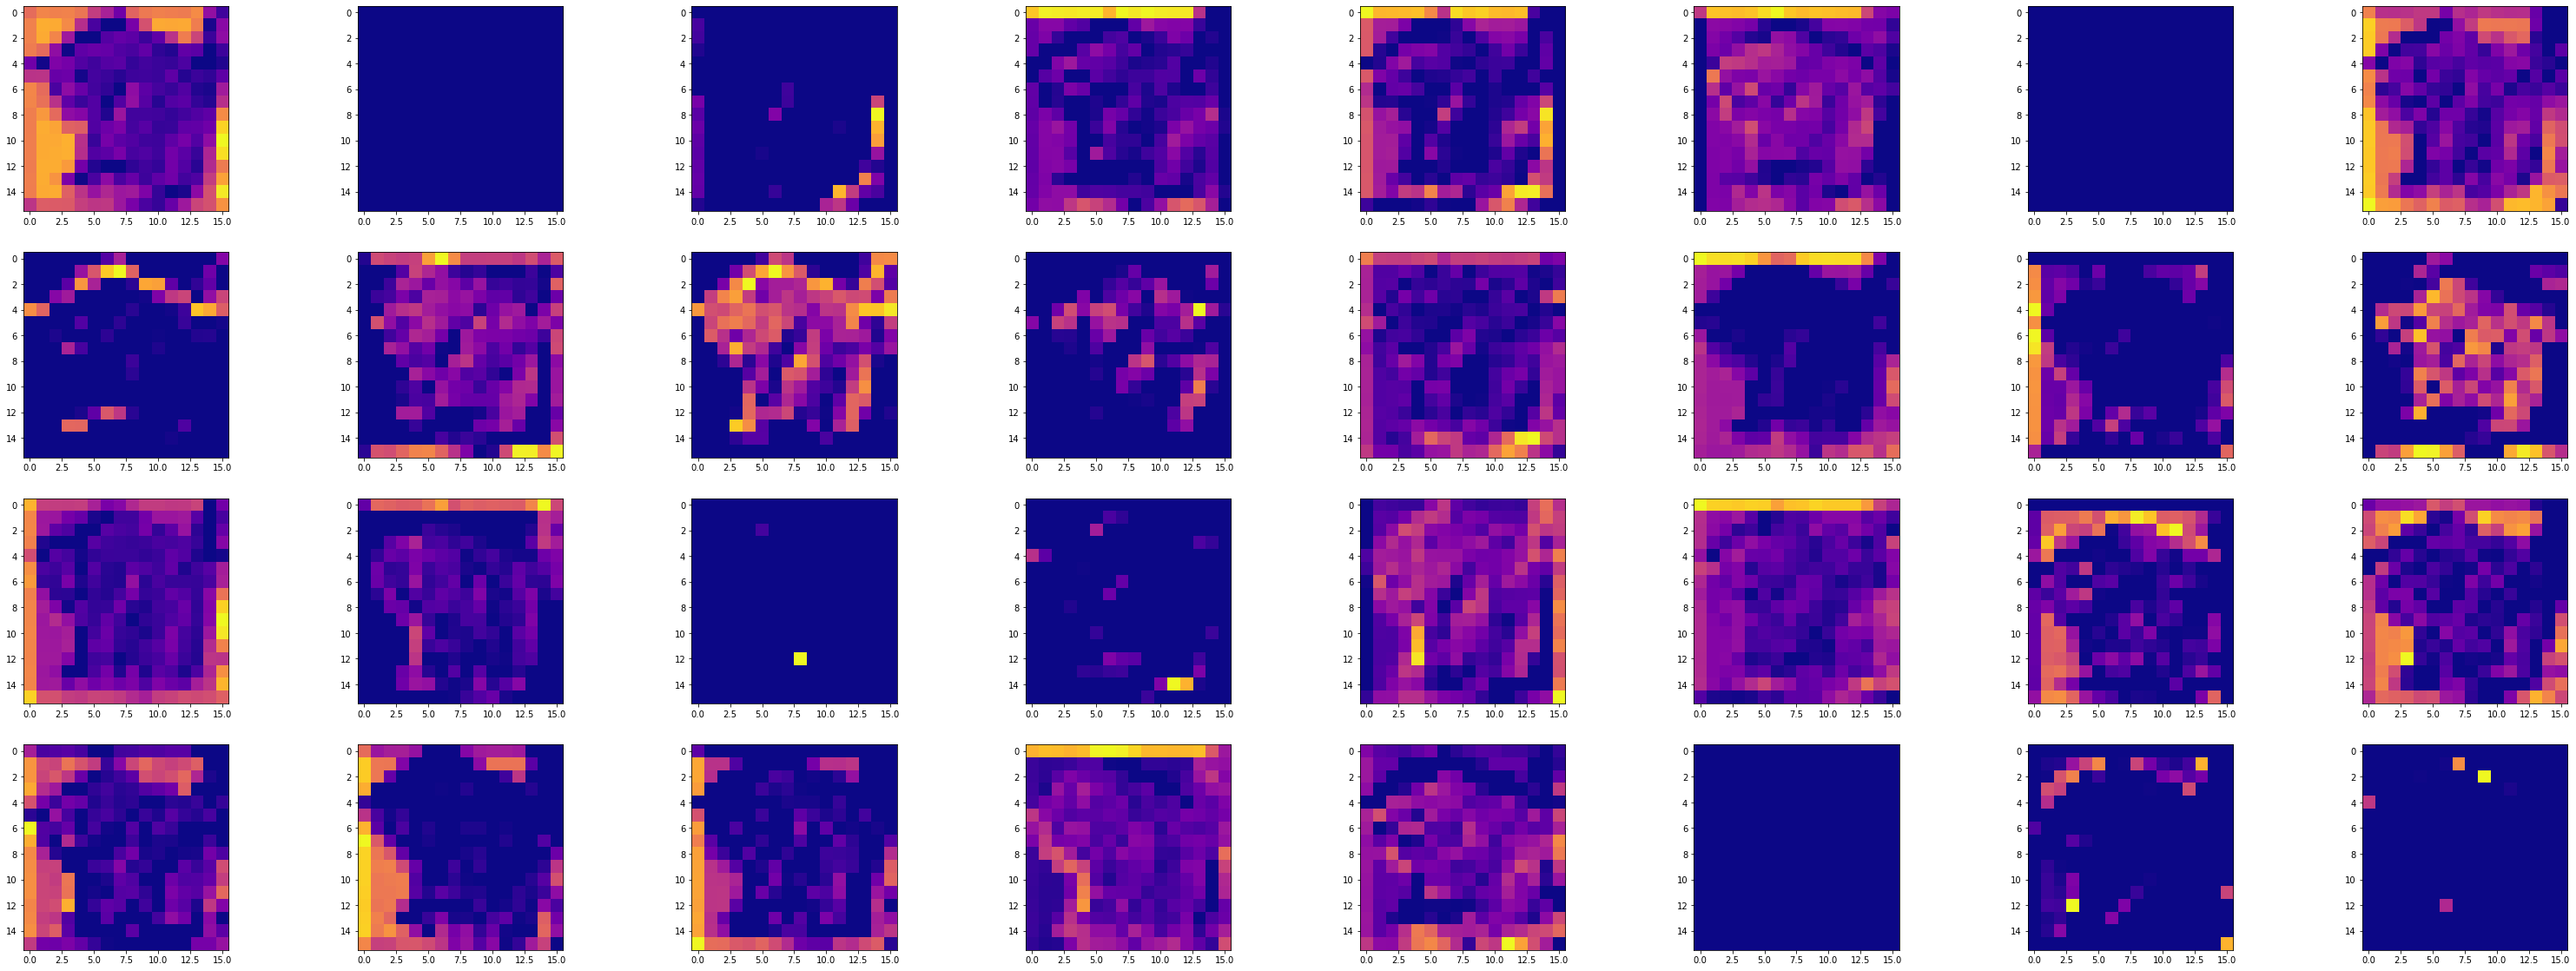

In [151]:
display_activation(activations, 8, 4, 3) # 2ème convolution

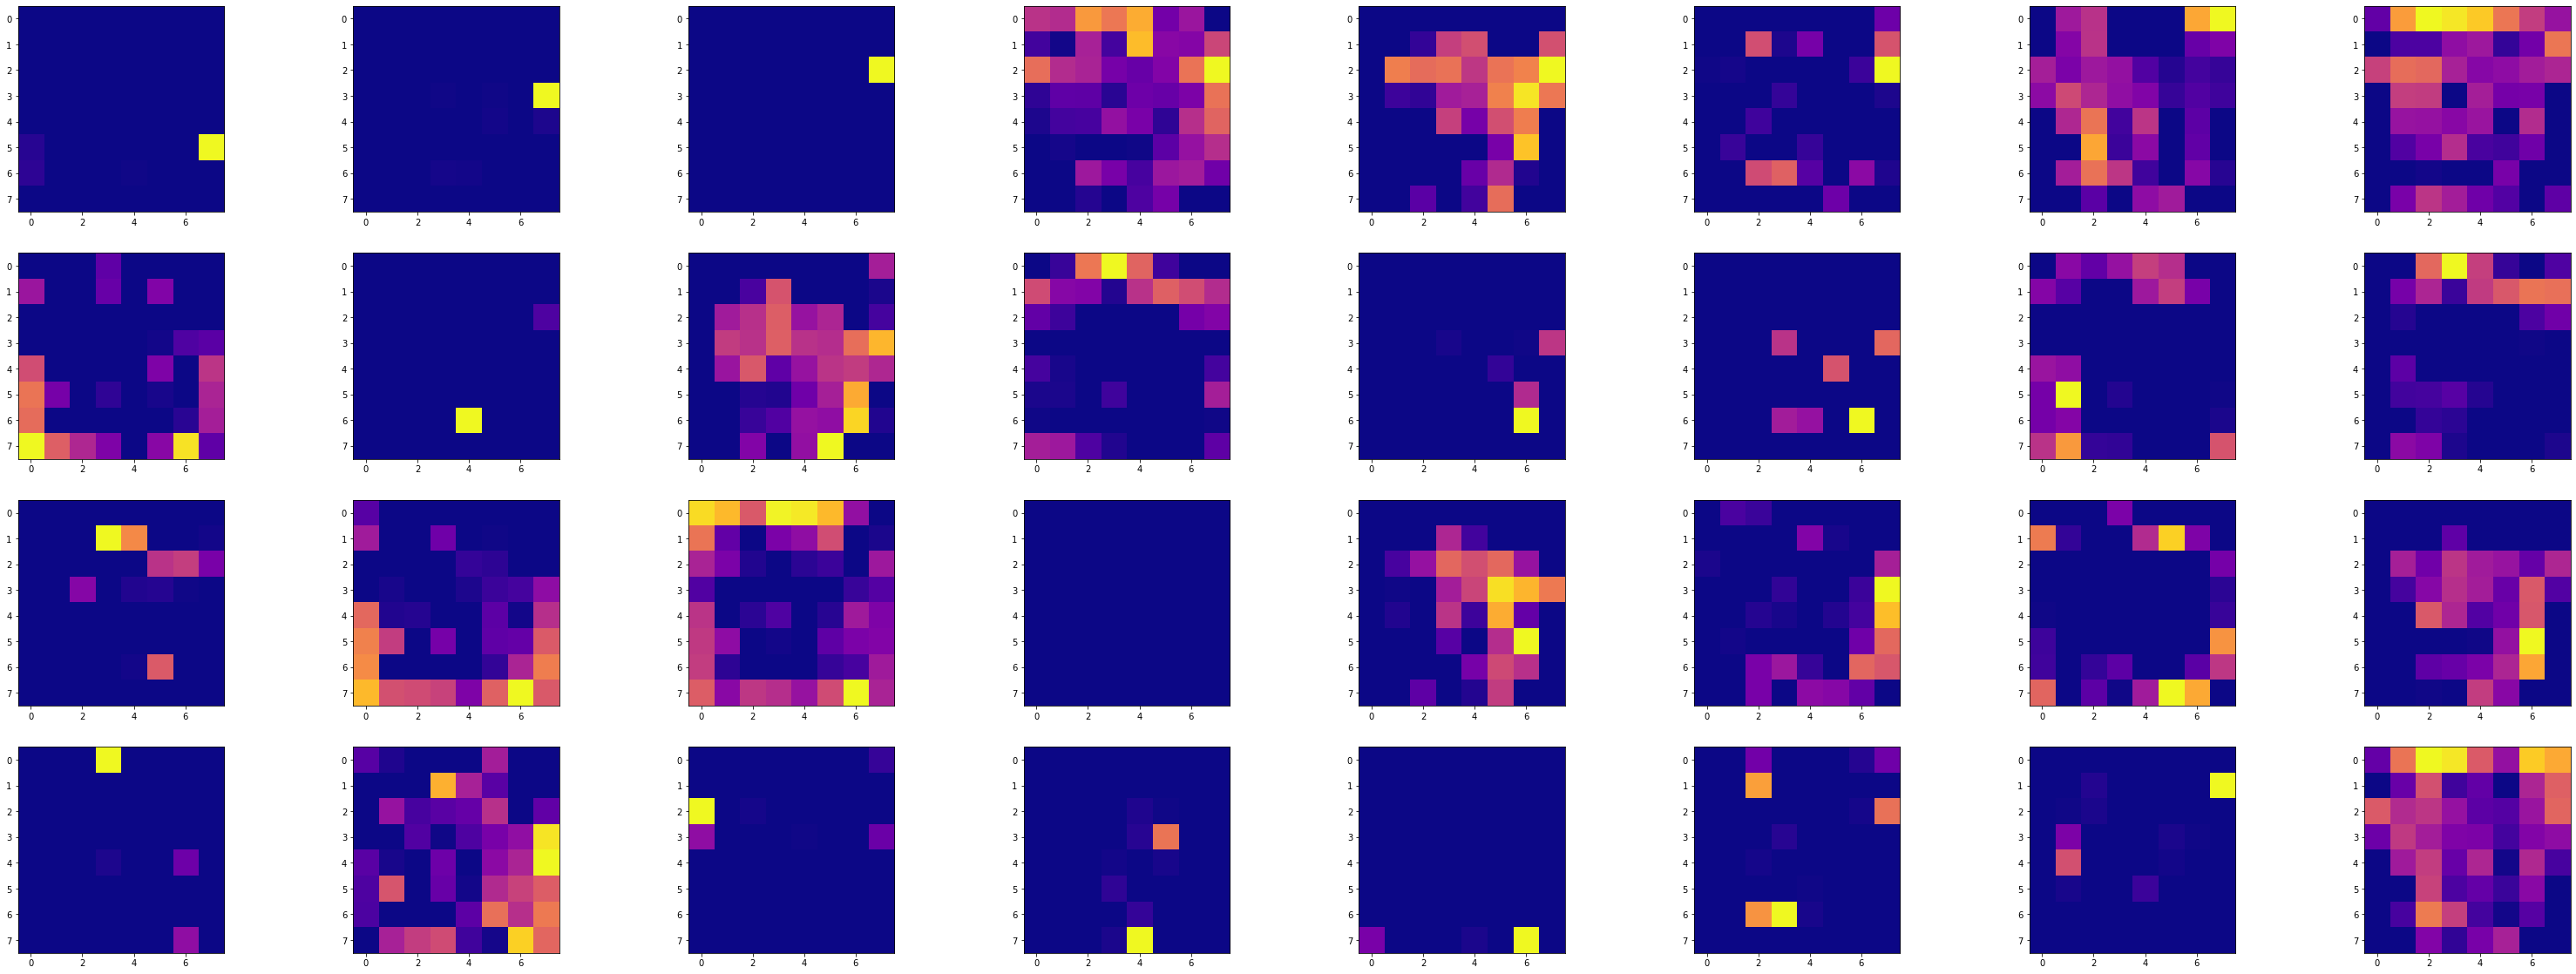

In [152]:
display_activation(activations, 8, 4, 7) # 3ème convolution

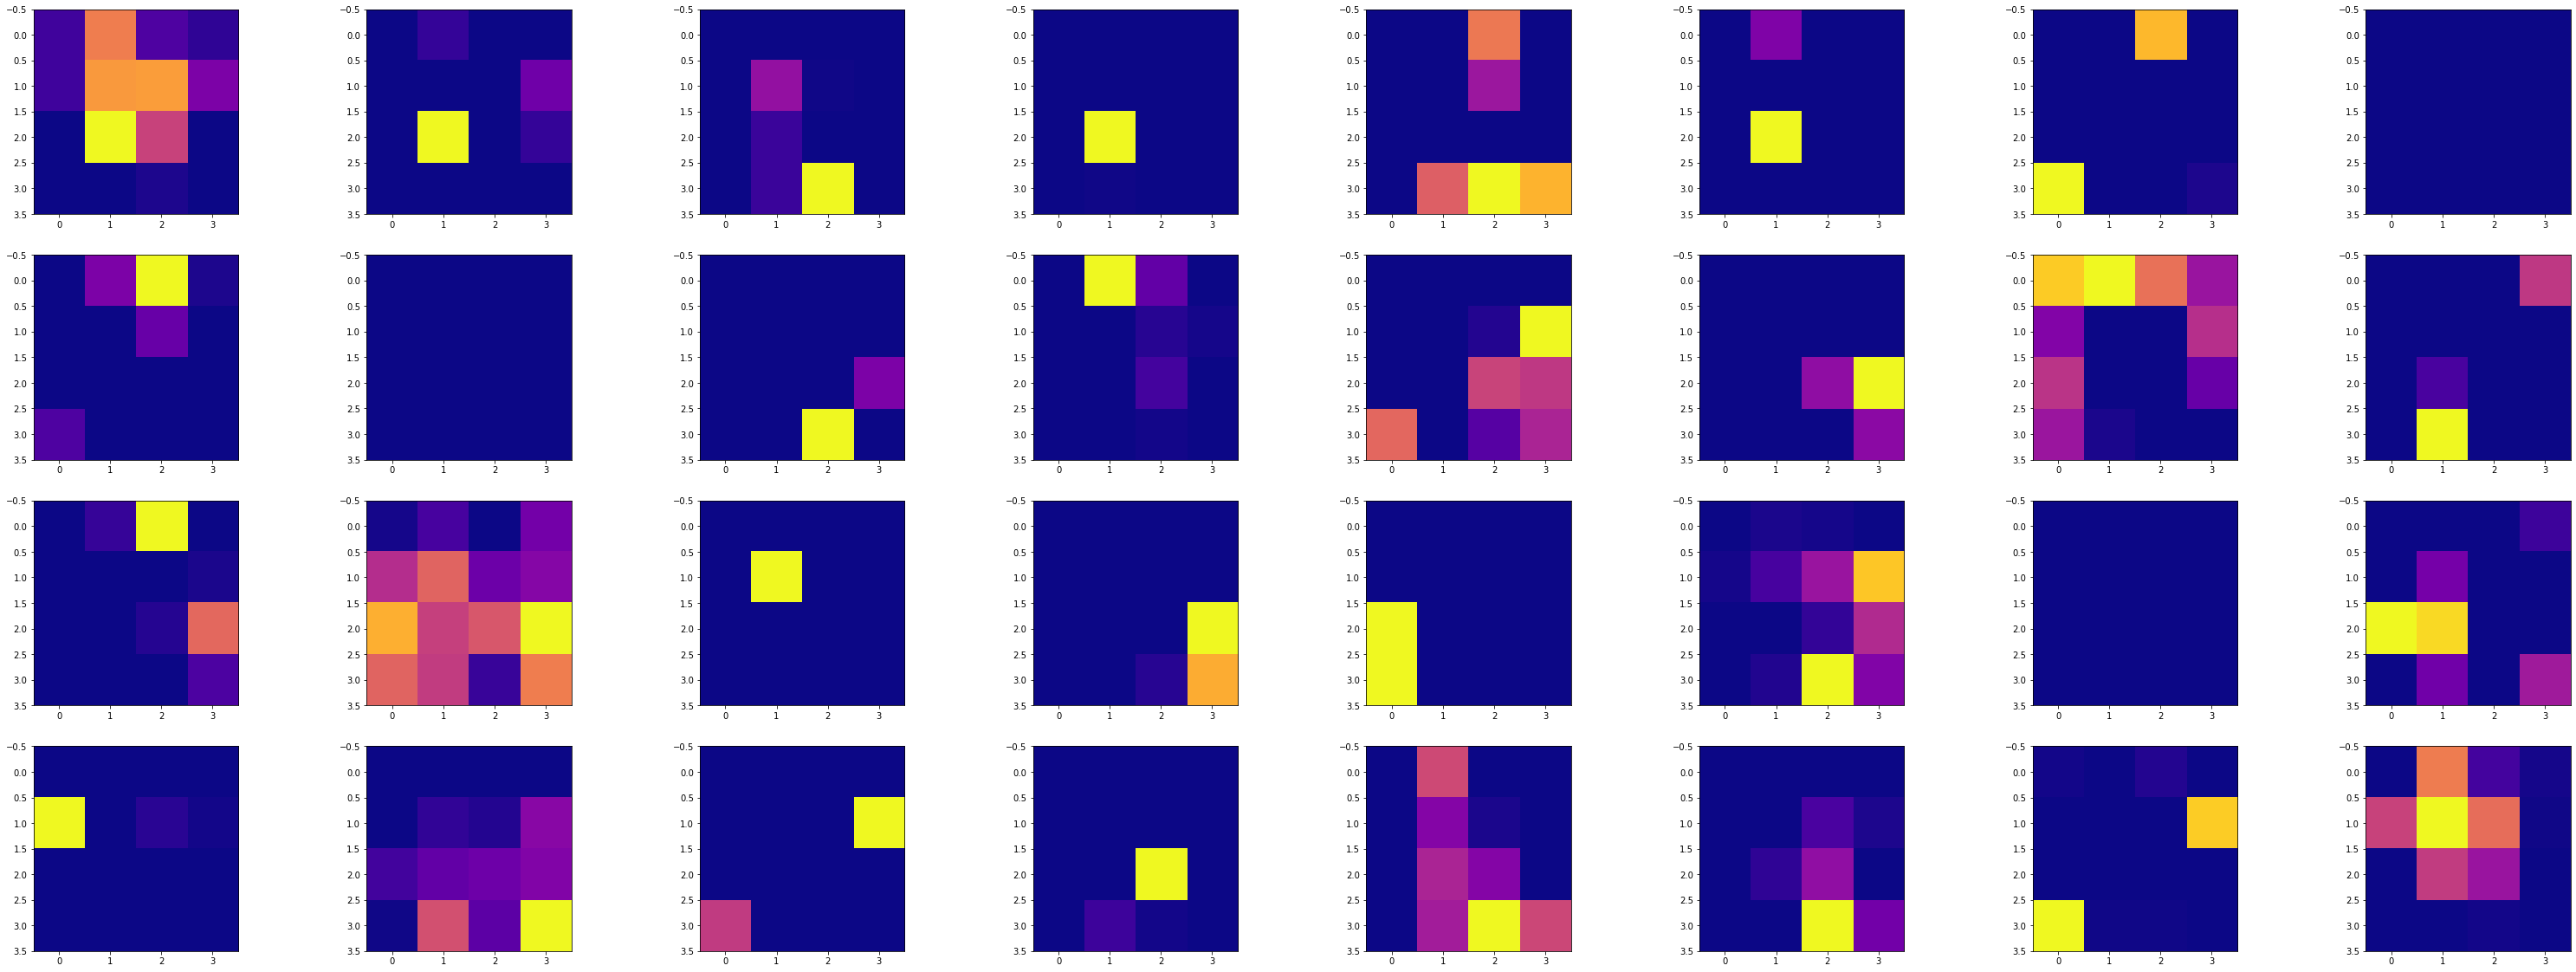

In [153]:
display_activation(activations, 8, 4, 10) # 4ème convolution

In [154]:
# Sauvegarder le modèle
model.save('model.h5')

In [155]:
# Initialisation du tableau des labels
labels_array = os.listdir(TRAIN_DATA_DIR)

Cet objet est un(e) "baby". probs=  55.64485788345337


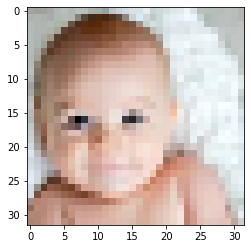

In [156]:
choix = r'./data/validation/bébé-1.png'

test_model = load_model('model.h5')

test_image = image.load_img(choix, target_size = (32, 32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)

index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "tank". probs=  98.95422458648682


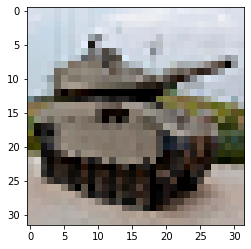

In [157]:
choix = r'./data/validation/tank-1.png'

test_model = load_model('model.h5')

test_image = image.load_img(choix, target_size = (32, 32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)

index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "beaver". probs=  93.52052807807922


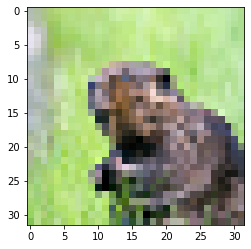

In [158]:
choix = r'./data/validation/castor-1.png'

test_model = load_model('model.h5')

test_image = image.load_img(choix, target_size = (32, 32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)

index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "bear". probs=  95.13459205627441


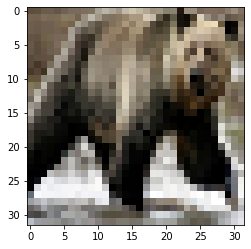

In [159]:
choix = r'./data/validation/ours-1.png'

test_model = load_model('model.h5')

test_image = image.load_img(choix, target_size = (32, 32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)

index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "aquarium_fish". probs=  85.03343462944031


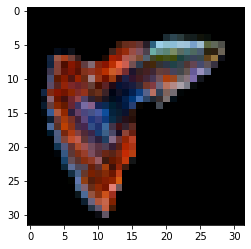

In [160]:
choix = r'./data/validation/poisson-1.png'

test_model = load_model('model.h5')

test_image = image.load_img(choix, target_size = (32, 32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)

index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "apple". probs=  95.91326713562012


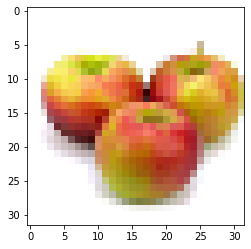

In [161]:
choix = r'./data/validation/pomme-1.png'

test_model = load_model('model.h5')

test_image = image.load_img(choix, target_size = (32, 32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)

index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "bed". probs=  95.77878713607788


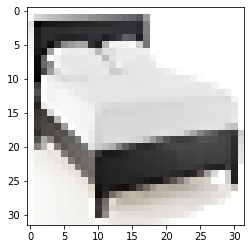

In [162]:
choix = r'./data/validation/lit-1.png'

test_model = load_model('model.h5')

test_image = image.load_img(choix, target_size = (32, 32))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)

index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)